<a href="https://colab.research.google.com/github/Bharathkrishnamurthy/21Day_21_ML-_project/blob/main/Day5_project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 5: Customer Segmentation with Clustering 🛍️

**Project Objective:** To use unsupervised machine learning to identify distinct groups of customers within a mall's dataset. By segmenting customers based on multiple dimensions (income, age, spending habits), we can provide rich, actionable insights to the marketing team for highly targeted campaigns.


### Core Concepts We'll Cover:
1.  **Unsupervised Learning:** Understanding the difference between supervised and unsupervised learning.
2.  **Clustering Fundamentals & K-Means:** A deep dive into how the K-Means algorithm works.
3.  **The Elbow Method:** A critical technique for finding the optimal number of clusters (`k`).
4.  **Multi-dimensional EDA:** Exploring relationships between all features using 2D and 3D plots.
5.  **Multiple Segmentation Models:** Building and interpreting different clustering models based on different feature sets.
6.  **Hierarchical Clustering:** A brief introduction to an alternative clustering method.
7.  **Data-Driven Personas:** Translating cluster statistics into actionable business strategies.

### **Theoretical Concept: What is Unsupervised Learning?**

So far, we have worked with **supervised learning**, where our datasets had a specific target variable we were trying to predict (e.g., `SalePrice`, `Survived`). The model *learns* the relationship between features and the known target.

**Unsupervised learning** is different. Here, we work with datasets that **do not have a target variable**. The goal is not to predict a known outcome, but to discover hidden patterns, structures, and relationships within the data itself.

**Clustering** is the most common type of unsupervised learning. The objective is to group data points into clusters, such that points within the same cluster are very similar to each other, and points in different clusters are very dissimilar.


### Step 1: Setup - Importing Libraries and Loading Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set_style('whitegrid')

In [4]:
# Load the dataset from the user-provided file
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/Mall_Customers.csv')

print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.
Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Step 2: Exploratory Data Analysis (EDA)
Before clustering, we must understand the features and their relationships to find the most promising dimensions for segmentation.

In [5]:
# Basic info and statistics
print("Dataset Info:")
df.info()

# Drop the CustomerID as it's just an identifier and not useful for clustering
df.drop('CustomerID', axis=1, inplace=True)

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     4

2.1 Univariate Analysis (Feature Distributions)


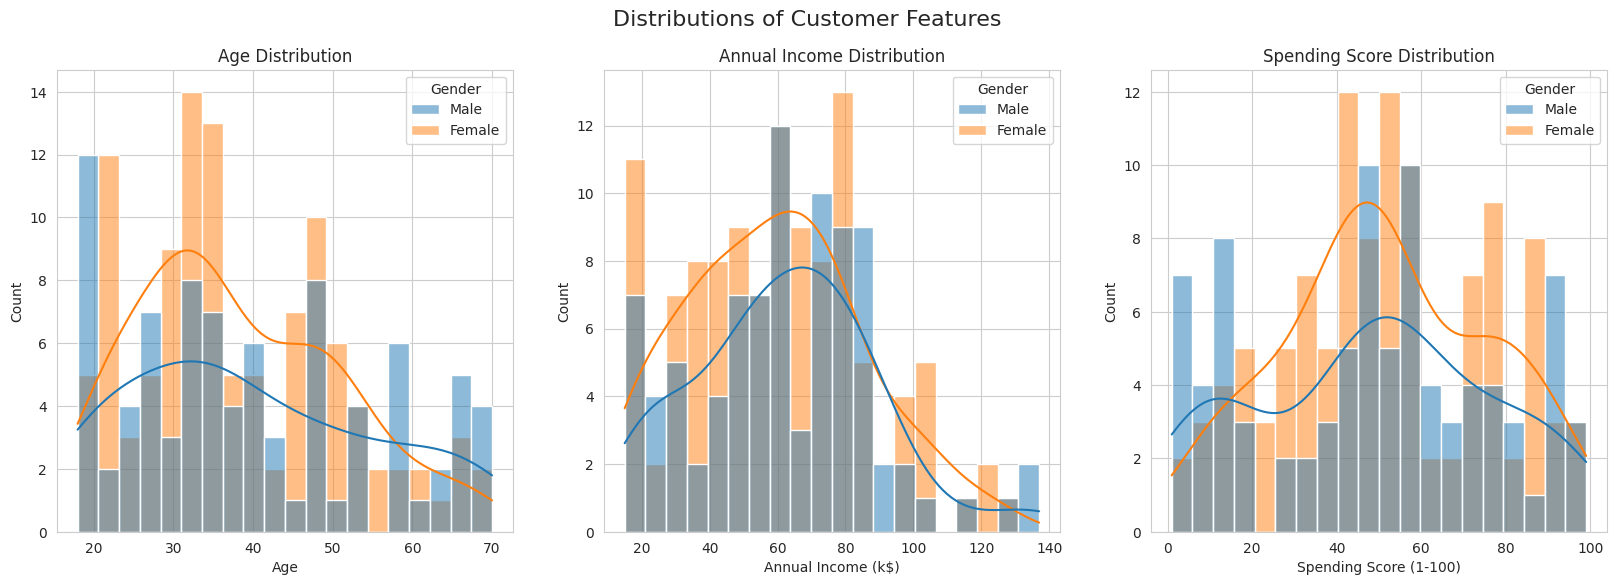

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Customer Features', fontsize=16)

sns.histplot(ax=axes[0], data=df, x='Age', kde=True, bins=20, hue='Gender').set_title('Age Distribution')
sns.histplot(ax=axes[1], data=df, x='Annual Income (k$)', kde=True, bins=20, hue='Gender').set_title('Annual Income Distribution')
sns.histplot(ax=axes[2], data=df, x='Spending Score (1-100)', kde=True, bins=20, hue='Gender').set_title('Spending Score Distribution')

plt.show()

In [8]:
df.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

#### 2.2 Bivariate Analysis (Looking for Relationships)

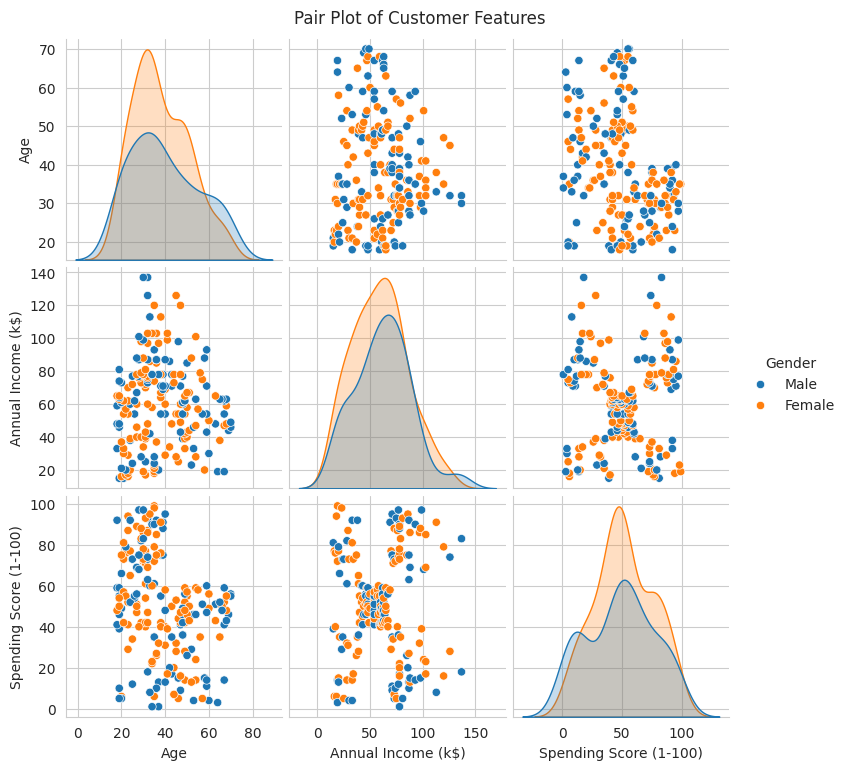

In [12]:
#  Using pairplot to visualize relationships between all numerical variables
sns.pairplot(df, vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue='Gender', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Features', y=1.02)
plt.show()

#### 2.3 3D Visualization
Let's visualize the three most important features together in an interactive 3D plot to see if the clusters hold up.

In [13]:
fig = px.scatter_3d(df,
                    x='Annual Income (k$)',
                    y='Spending Score (1-100)',
                    z='Age',
                    color='Gender',
                    title='3D View of Customer Data')
fig.show()

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.


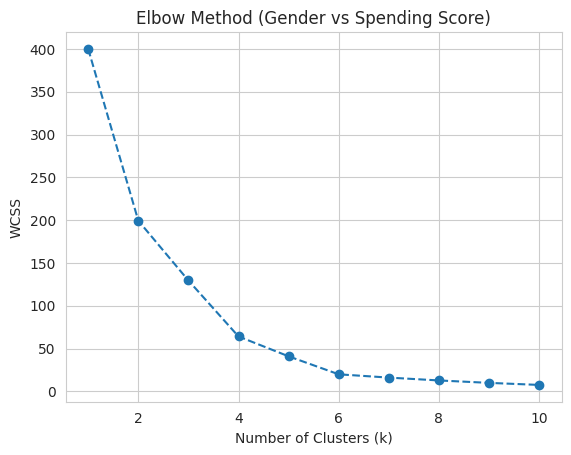

In [57]:
# Load the dataset from the user-provided file
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/Mall_Customers.csv')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Clean column names
df.columns = df.columns.str.strip()

# Map gender safely
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# ✅ Fill missing values without inplace warning
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Spending Score (1-100)'] = df['Spending Score (1-100)'].fillna(df['Spending Score (1-100)'].median())

# Select and scale
X = df[['Gender', 'Spending Score (1-100)']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method (Gender vs Spending Score)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()


In [60]:
# Build and fit the final model
kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['Income_Cluster'] = kmeans1.fit_predict(X_scaled)

#### 3.1 Visualizing and Interpreting the Income-Based Segments

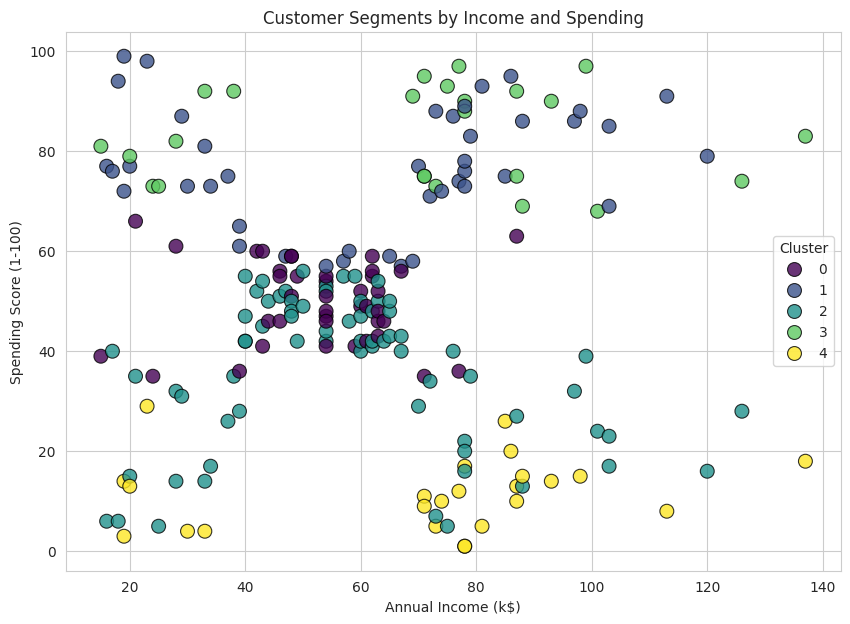

In [62]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Income_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Income and Spending')
plt.legend(title='Cluster')
plt.show()

In [63]:
# Quantitative Persona Analysis
cluster_profiles1 = df.groupby('Income_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles1['Size'] = df['Income_Cluster'].value_counts()
print("--- Income-Based Cluster Profiles ---")
cluster_profiles1

--- Income-Based Cluster Profiles ---


,Age,Annual Income (k$),Spending Score (1-100),Size
Income_Cluster,,,,
0,43.35,52.82,49.88,40
1,31.93,61.83,76.93,42
2,41.80,57.70,36.29,70
3,30.71,69.33,83.21,24
4,43.00,70.79,11.54,24


### Step 4: Segmentation Model 2 - Age & Spending Score
Let's create a different segmentation model to see if we can find age-related customer groups.

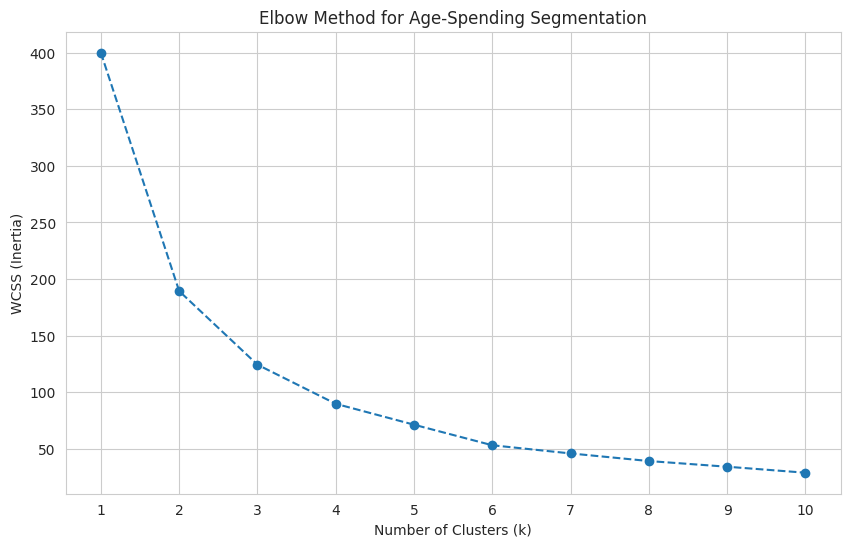

In [65]:
# 1. Select and scale the features
X2 = df[['Age', 'Spending Score (1-100)']]
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# 2. Implement the Elbow Method
wcss2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X2_scaled)
    wcss2.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss2, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

### Step 5: An Alternative Method - Hierarchical Clustering
To add more depth, let's briefly look at another clustering technique.



#### **Theoretical Concept: Hierarchical Clustering & Dendrograms**
Unlike K-Means, Hierarchical Clustering doesn't require us to specify the number of clusters beforehand. It builds a tree-like hierarchy of clusters.

We can visualize this hierarchy with a **dendrogram**. The dendrogram shows how clusters are merged (or split). To find the optimal number of clusters, we look for the tallest vertical line that doesn't cross any horizontal lines and draw a horizontal line through it. The number of vertical lines our new line crosses is the optimal number of clusters.


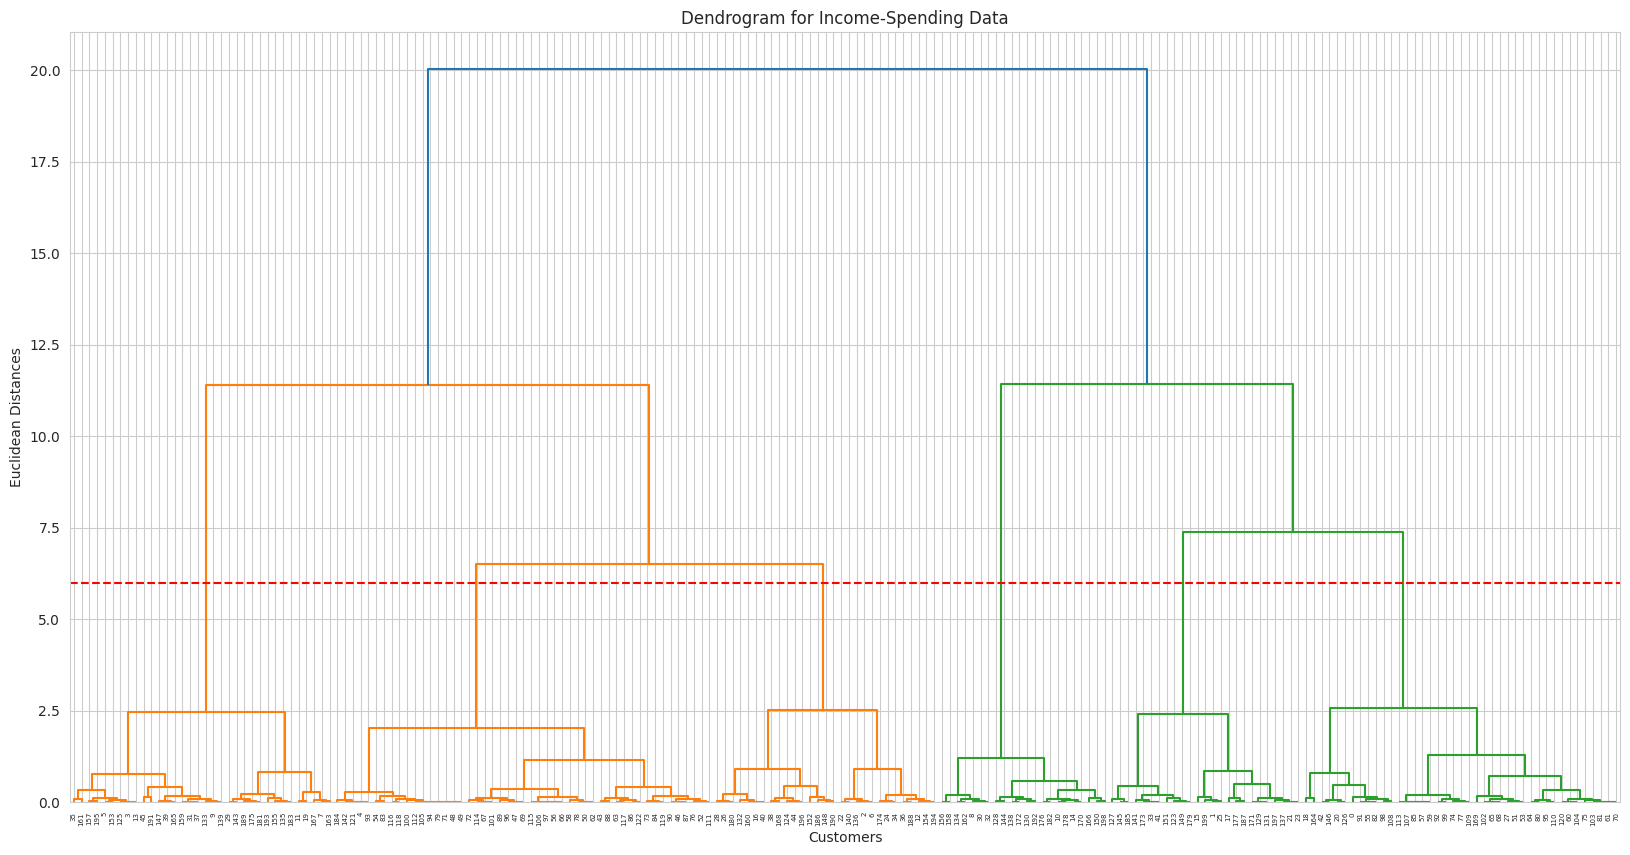

In [66]:
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title('Dendrogram for Income-Spending Data')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=6, color='r', linestyle='--') # Example cut-off line
plt.show()

SUNMISSION QUESTIONS

        count       mean       std  min   25%   50%   75%   max
Gender                                                         
0        88.0  48.511364  27.89677  1.0  24.5  50.0  70.0  97.0
1       112.0  51.526786  24.11495  5.0  35.0  50.0  73.0  99.0


/tmp/ipython-input-2033147992.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




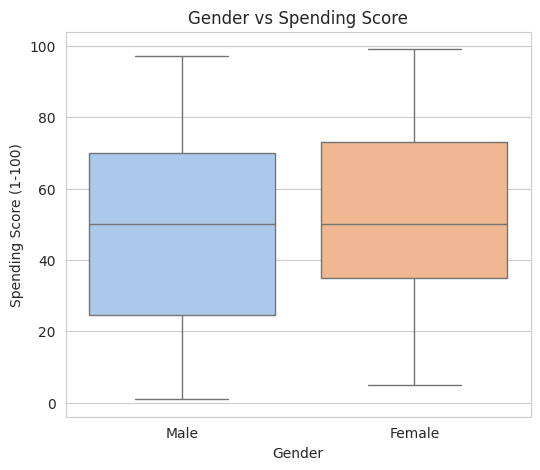

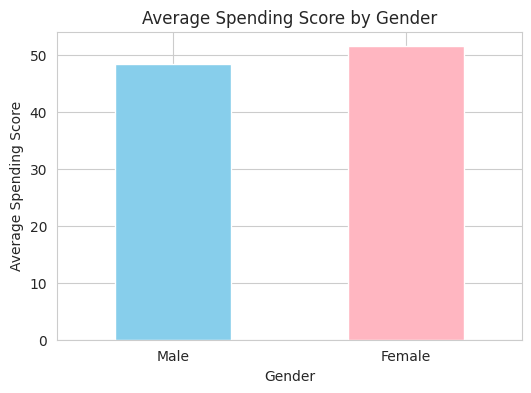

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summary stats
print(df.groupby('Gender')['Spending Score (1-100)'].describe())

# Boxplot: Gender vs Spending Score
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x='Gender', y='Spending Score (1-100)', palette='pastel')
plt.title('Gender vs Spending Score')
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()

# Mean spending by gender
plt.figure(figsize=(6,4))
df.groupby('Gender')['Spending Score (1-100)'].mean().plot(kind='bar', color=['skyblue', 'lightpink'])
plt.title('Average Spending Score by Gender')
plt.ylabel('Average Spending Score')
plt.xticks([0, 1], ['Male', 'Female'], rotation=0)
plt.show()


CREATING NEW FEATURE FROM EXISTING FEATURE

In [68]:
# Example feature: Purchase Potential = Income * (Spending Score / 100)
df['Purchase Potential'] = df['Annual Income (k$)'] * (df['Spending Score (1-100)'] / 100)


In [69]:
df['Purchase Potential']

,Purchase Potential
0,5.85
1,12.15
2,0.96
3,12.32
4,6.80
...,...
195,94.80
196,35.28
197,93.24
198,24.66


In [78]:
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Income_Cluster,Purchase Potential,Cluster
0,1,0,19,15,39,0,5.85,2
1,2,0,21,15,81,3,12.15,0
2,3,1,20,16,6,2,0.96,2
3,4,1,23,16,77,1,12.32,0
4,5,1,31,17,40,2,6.80,2


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              200 non-null    int64  
 1   Gender                  200 non-null    int64  
 2   Age                     200 non-null    int64  
 3   Annual Income (k$)      200 non-null    int64  
 4   Spending Score (1-100)  200 non-null    int64  
 5   Income_Cluster          200 non-null    int32  
 6   Purchase Potential      200 non-null    float64
 7   Cluster                 200 non-null    int32  
dtypes: float64(1), int32(2), int64(5)
memory usage: 11.1 KB


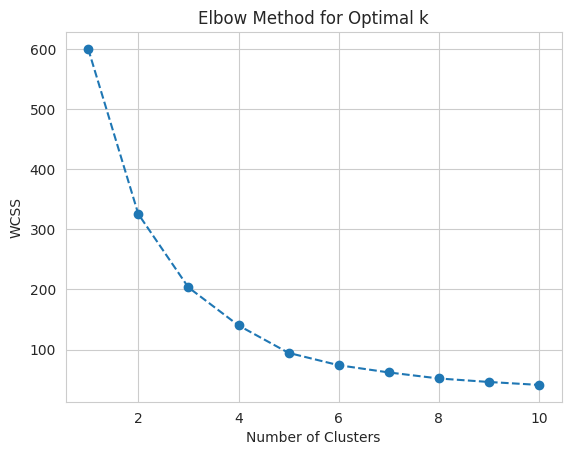

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Select and scale
X = df[['Annual Income (k$)', 'Spending Score (1-100)', 'Purchase Potential']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Elbow method
wcss = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


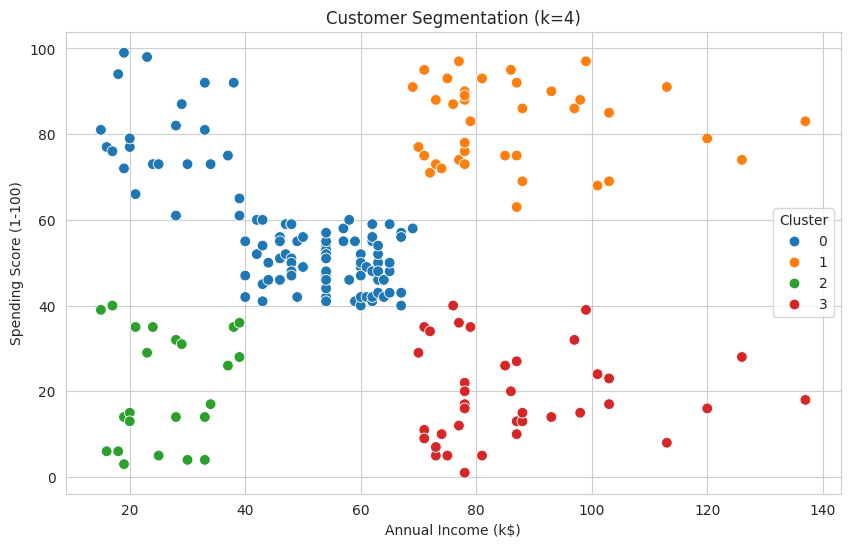

In [76]:
k = 4 # example; adjust based on elbow result
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# 2D visualization (Income vs Spending Score)
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', palette='tab10', s=60)
plt.title(f'Customer Segmentation (k={k})')
plt.show()


# ***CONCLUSION:***

| Section                         | Description                                                                              |
| ------------------------------- | ---------------------------------------------------------------------------------------- |
| **1. Gender vs Spending Score** | Showed gender-wise distribution, boxplots, and summary statistics.                       |
| **2. Feature Engineering**      | Created new feature `Purchase Potential` = Income × Spending Score / 100.                |
| **3. Clustering**               | Applied Elbow Method, selected optimal `k`, visualized clusters, and interpreted groups. |
